### Load model

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [74]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(180, 180)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

test_dir = "./data/validation"  # path to the validation folder

test_data = datasets.ImageFolder(root=test_dir, transform=transform)


print(f"Test data:\n{test_data}")

Test data:
Dataset ImageFolder
    Number of datapoints: 989
    Root location: ./data/validation
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [75]:
batch_size = 1
num_workers = 2

test_set = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
)  # dont usually need to shuffle testing data

test_set

In [76]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(32 * 45 * 45, 128)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.pool1(self.act1(self.bn1(self.conv1(x))))
        out = self.pool2(self.act2(self.bn2(self.conv2(out))))
        out = out.view(out.size(0), -1)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out


model = SimpleCNN()

model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64800, out_features=128, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [77]:
model = SimpleCNN()
model.load_state_dict(torch.load("./nets/skynet-2.pth"))

E:\AppData\Local\Temp\ipykernel_28736\3679876447.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./nets/skynet-2.pth"))


<All keys matched successfully>

### FGSM attack

In [78]:
# epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
epsilons = [0, 0.0001, 0.0003, 0.0005, 0.001, 0.0015, 0.002]
use_cuda = True
# Set random seed for reproducibility
torch.manual_seed(42)

In [79]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image


# restores the tensors to their original scale
def denorm(batch, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, (list, tuple)):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, (list, tuple)):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [80]:
def test(model, device, test_loader, epsilon):
    # Counter for correct predictions
    correct = 0
    # Stores example images (initial prediction, final after attack, tensor)
    adv_examples = []

    # Loop through the entire test set
    for data, target in test_loader:
        # Send data to GPU/CPU
        data, target = data.to(device), target.to(device)

        # Enable gradient computation for data (attack requires input gradients)
        data.requires_grad = True

        # Forward pass – classify original data
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # index of max logit

        # Skip attack if the initial prediction is incorrect (already wrong)
        if init_pred.item() != target.item():
            continue

        # Compute loss – assuming output contains raw logits
        loss = F.cross_entropy(output, target)

        # Zero out gradients in the model
        model.zero_grad()

        # Backward pass – compute gradient of loss with respect to input data
        loss.backward()

        # Retrieve the sign of the gradient
        data_grad = data.grad.data.sign()

        # Add FGSM perturbation directly in the normalized scale
        perturbed_data = data + epsilon * data_grad

        # If our data (after normalization) is in the range [-1, 1], clamp it to [-1, 1].
        # (With Normalize(mean=0.5, std=0.5), input [0, 1] maps to [-1, 1].)
        perturbed_data = torch.clamp(perturbed_data, -1, 1)

        # Classification after the attack
        output_perturbed = model(perturbed_data)
        final_pred = output_perturbed.max(1, keepdim=True)[1]

        # Check if it still classifies correctly
        if final_pred.item() == target.item():
            correct += 1
            # Save example if epsilon=0 (no attack)
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save example if there are fewer than 5
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Compute final accuracy
    final_acc = correct / float(len(test_loader))
    print(
        f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}"
    )

    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_set, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 909 / 989 = 0.9191102123356926
Epsilon: 0.0001	Test Accuracy = 879 / 989 = 0.8887765419615774
Epsilon: 0.0003	Test Accuracy = 820 / 989 = 0.8291203235591507
Epsilon: 0.0005	Test Accuracy = 744 / 989 = 0.7522750252780587
Epsilon: 0.001	Test Accuracy = 510 / 989 = 0.5156723963599595
Epsilon: 0.0015	Test Accuracy = 274 / 989 = 0.2770475227502528


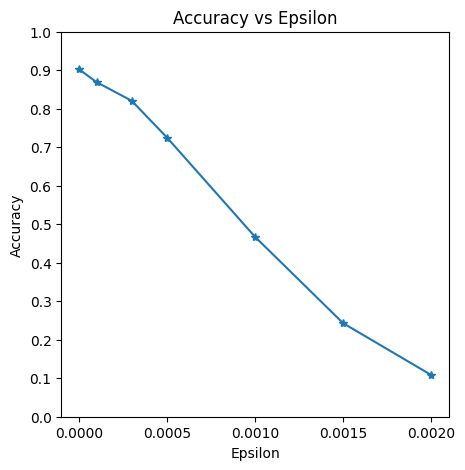

7
7


In [62]:
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.0025, step=0.0005))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

print(len(epsilons))
print(len(examples))

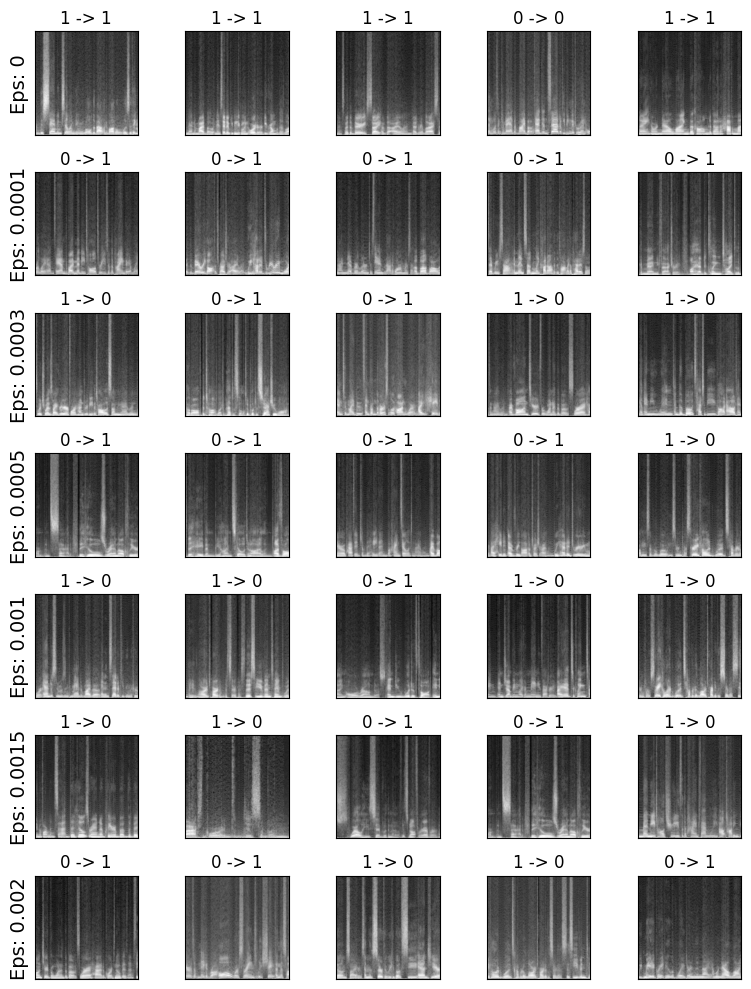

In [72]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")

        # To gray
        gray_image = ex.mean(axis=0)
        plt.imshow(gray_image, cmap='gray')
plt.tight_layout()
plt.show()